In [54]:
''' Import libraries '''
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display

In [55]:
''' Load image using OpenCV '''
# Upload the LMS image to Google Drive and point to its location.
# Note OpenCV reads image as BGR.
# image_directory = '/home/phw93/dev/calib/data/*.jpg'
image_directory = '/home/phw/dev/calib/data/*.jpg'
image_files = glob.glob(image_directory)
image_files = sorted(image_files)
images = []
gray_images = []
for image_file in image_files:
    image = cv2.imread(image_file)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    images.append(image)
    gray_images.append(gray_image)
    
images_len = len(gray_images)
# Normalize image to between 0 and 1.

checkboard = [8,6]
w, h = gray_images[0].shape
print(w, h)
print("image len: ", images_len)
print(checkboard[0], checkboard[1])

1920 1080
image len:  1137
8 6


float32
0.019607844 1.0


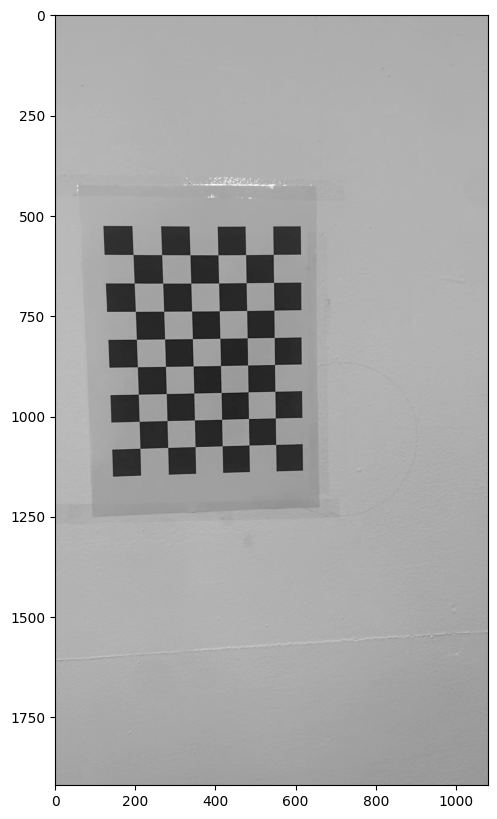

In [56]:
# Show output
print(gray_images[0].dtype)
print(np.min(gray_images[0]), np.max(gray_images[0]))
plt.figure(figsize=(10, 10))
plt.imshow(gray_images[5], cmap='gray')
plt.show()

In [57]:
# Perform Sobel filtering along the x-axis, y-axis.
arrIx = []
arrIy = []
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

for gray_image in gray_images:
    Ix = cv2.filter2D(gray_image, -1, sobel_x)
    Iy = cv2.filter2D(gray_image, -1, sobel_y)
    arrIx.append(Ix)
    arrIy.append(Iy)

print(len(arrIx))    

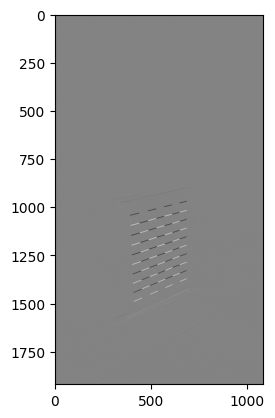

In [ ]:
plt.imshow(arrIx[111], cmap='gray')
plt.imshow(arrIy[111], cmap='gray')

In [ ]:
# extract corner & NMS
arrCorners = []

window_size = 3
half_size = window_size // 2

for gray_image in gray_images:
    max_corners = 100   # 최대 코너 개수
    quality_level = 0.01  # 코너 품질 임계값 (0 ~ 1 사이의 값)
    min_distance = 20  # 검출된 코너 간의 최소 거리
    mask = np.empty((0, 0), dtype=np.float32)
    corners = cv2.goodFeaturesToTrack(gray_image, max_corners, quality_level, min_distance, mask, blockSize=3, useHarrisDetector=True, k=0.04)
    arrCorners.append(corners)
    
for corners in arrCorners:
    print(len(corners))

97
98
90
98
84
81
80
81
81
81
82
81
98
91
99
90
97
100
100
100
100
93
92
100
99
91
86
82
81
81
81
81
82
81
81
81
81
80
90
94
100
100
100
94
98
97
96
100
100
98
100
100
100
96
94
92
91
92
92
85
93
100
94
94
92
89
91
88
91
92
79
67
96
66
79
83
93
81
91
100
52
92
92
91
70
90
91
100
82
100
60
100
98
100
100
90
92
89
93
86
81
82
81
81
81
81
80
80
80
81
80
81
80
80


In [ ]:
# draw corners
cornerImg = []
filtCorners =[]
for image, corners in zip(images, arrCorners):
    if(len(corners)>=80):
        continue    
    temp = image.copy()
    filtCorners.append(corners)
    for corner in corners:
        x, y = corner[0, 0].astype(int), corner[0, 1].astype(int)
        cv2.drawMarker(temp, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_STAR, markerSize=5, thickness=1)        
    cornerImg.append(temp)

7
79


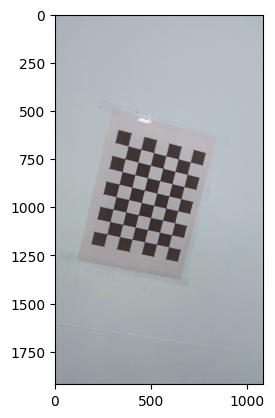

In [ ]:
# 이미지 표시
plt.imshow(cornerImg[0], cmap='gray')
print(len(filtCorners))
print(len(filtCorners[0]))